<a href="https://colab.research.google.com/github/paragdhankhart1dm/t1dmProject/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and prep

In [1]:
!apt remove python3-xlrd
!apt remove python-xlrd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python3-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!pip uninstall -y xlrd
!pip install xlrd==1.2.0

Found existing installation: xlrd 1.1.0
Uninstalling xlrd-1.1.0:
  Successfully uninstalled xlrd-1.1.0
     |████████████████████████████████| 103 kB 5.3 MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
import time
import re
from sklearn.preprocessing import MinMaxScaler

#for training 
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Input, Activation
from keras.callbacks import EarlyStopping

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# s_data = "/content/gdrive/MyDrive/project/s-data/*"
# !cp -r $s_data /content/

In [5]:
!git clone https://github.com/paragdhankhart1dm/t1dmProject
!cp t1dmProject/data/* /content/

Cloning into 't1dmProject'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


# File selection

In [6]:
files = os.listdir('/content/')
removes = []
for x in range(0,len(files)):
  if('.xlsx' not in files[x] or 'Patient' not in files[x]):
    removes.append(files[x])
    continue
  print(x+1 - len(removes),files[x])

for f in removes:
  files.remove(f)
print(files)
print('--------------------------')
# selected_file = files[int(input("Select a file: "))-1]
# print(selected_file,'was selected')


1 Patient1_Sep2018.xlsx
2 Patient2_Oct2018.xlsx
3 Patient5_Mar2019.xlsx
4 Patient7_Oct2019.xlsx
5 Patient4_Feb2019.xlsx
6 Patient3_Mar2019.xlsx
7 Patient1_Aug2018.xlsx
8 Patient2_Nov2018.xlsx
9 Patient7_Sep2019.xlsx
10 Patient3_Apr2019.xlsx
11 Patient6_Jul2019.xlsx
12 Patient5_May2019.xlsx
13 Patient3_Feb2019.xlsx
14 Patient7_Aug2019.xlsx
15 Patient6_Aug2019.xlsx
16 Patient5_Apr2019.xlsx
17 Patient4_Mar2019.xlsx
['Patient1_Sep2018.xlsx', 'Patient2_Oct2018.xlsx', 'Patient5_Mar2019.xlsx', 'Patient7_Oct2019.xlsx', 'Patient4_Feb2019.xlsx', 'Patient3_Mar2019.xlsx', 'Patient1_Aug2018.xlsx', 'Patient2_Nov2018.xlsx', 'Patient7_Sep2019.xlsx', 'Patient3_Apr2019.xlsx', 'Patient6_Jul2019.xlsx', 'Patient5_May2019.xlsx', 'Patient3_Feb2019.xlsx', 'Patient7_Aug2019.xlsx', 'Patient6_Aug2019.xlsx', 'Patient5_Apr2019.xlsx', 'Patient4_Mar2019.xlsx']
--------------------------


In [7]:
#@title Select file, training date, prediction horizon { run: "auto", vertical-output: true, display-mode: "both" }
patient_name = "Divitry Palette" #@param {type:"string"}
gender = "M" #@param ["M", "F", "O"]
selected_file = "Patient4_Feb2019.xlsx" #@param ['Patient7_Aug2019.xlsx', 'Patient1_Sep2018.xlsx', 'Patient6_Aug2019.xlsx', 'Patient5_Apr2019.xlsx', 'Patient5_May2019.xlsx', 'Patient3_Mar2019.xlsx', 'Patient2_Oct2018.xlsx', 'Patient5_Mar2019.xlsx', 'Patient6_Jul2019.xlsx', 'Patient2_Nov2018.xlsx', 'Patient4_Feb2019.xlsx-training-test.txt', 'Patient7_Oct2019.xlsx', 'Patient1_Aug2018.xlsx', 'Patient3_Feb2019.xlsx', 'Patient3_Apr2019.xlsx', 'Patient4_Feb2019.xlsx', 'Patient7_Sep2019.xlsx', 'Patient4_Mar2019.xlsx']
training_start = "2019-02-21" #@param {type:"date"}
training_end = "2019-02-22" #@param {type:"date"}
testing_date = "2019-02-23" #@param {type:"date"}
print(selected_file,'was selected')

Patient4_Feb2019.xlsx was selected


In [8]:
#========================================================================================
#Write result of experiment in a file

def write_file(file_name, write_mode, write_string):
    '''
    Input: Output file name, Write mode, Write string
    Output: Writes result to the output file
    '''
    output_file = open(file_name, write_mode)
    output_file.write(write_string)
    output_file.write('\n\n')
    output_file.write('-------------------------------------------------------------------------')
    output_file.write('\n\n')
    output_file.close()

test_file_name = selected_file+"-training-test.txt"
# #Write output in a result file
# write_string = f'Experiment number: {experiment} \nTest case: {testcase} \nModel used: {model_name}'
# test_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_{current_datetime}.txt'
# write_file( test_file_name, 'w', write_string)

# write_string = f'Experiment Done at Google Collab \nTime of Experiment: {current_datetime} (GMT) \nProcessor for model training: CPU'
# write_file( test_file_name, 'a', write_string)

# write_string = f'Input Variables: \nPatient: {patient} \ntraining_date: {training_date} \ntesting_date: {testing_date} \nbg_unit: {bg_unit}'
# write_string = write_string + f'\ninput_features: {input_features} \nhistory_points: {history_points} (12 history_points/hour) \nbatch_size: {batch_size}'
# write_string = write_string + f'\nlearning_rate: {learning_rate} \nValidation_split: {validation_split}'
# write_string = write_string + f'\nprediction_horizon: {prediction_horizon} ({prediction_horizon*5} minutes)'
# write_file( test_file_name, 'a', write_string)

# Clean and organize

In [9]:
insulin_sheet = "Step_5"
insulin_data = pd.read_excel(selected_file,sheet_name=insulin_sheet)
print('Insulin data')
print(insulin_data.head())
print(insulin_data.info())

Insulin data
    CGM_DATE APPROX_CGM_TIME Event Type  Glucose Value (mmol/L)     Basal  \
0 2019-02-20        00:00:00        EGV                    13.1  0.079167   
1 2019-02-20        00:05:00        EGV                    13.5  0.079167   
2 2019-02-20        00:10:00        EGV                    13.4  0.079167   
3 2019-02-20        00:15:00        EGV                    13.3  0.079167   
4 2019-02-20        00:20:00        EGV                    13.2  0.079167   

   Bolus  Carbs_gm  Gender  Weight  Height  Baseline HbA1c (mmol/mol)  \
0    0.0         0  Female    69.4     169                         95   
1    0.0         0  Female    69.4     169                         95   
2    0.0         0  Female    69.4     169                         95   
3    0.0         0  Female    69.4     169                         95   
4    0.0         0  Female    69.4     169                         95   

         Age  Duration DM        BMI  WEEKDAY  HOUR  
0  19.476712      7.00274  24.2

In [10]:
training_month = 'Feb2019' #Give training data month here - refer actual file name for this
# training_date = ['2019-08-16 00:00:00', '2019-08-17 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
training_date = [str(training_start)+' 00:00:00', str(training_end)+' 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_month = 'Feb2019' #Give testing data month here - refer actual file name for this
# testing_date = ['2019-08-18 00:00:00', '2019-08-18 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_date = [str(testing_date)+' 00:00:00', str(testing_date)+' 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
bg_unit = 'Glucose Value  mmol/L' #or Glucose Value (mmol/L)
input_features = [bg_unit, 'Basal', 'Bolus', 'Carbs_gm']

In [11]:
filtered_idata = insulin_data.copy()
filtered_idata['DateTime'] = (str(filtered_idata['CGM_DATE']) + str(' ') + str(filtered_idata['APPROX_CGM_TIME']))
filtered_idata['DateTime'] = pd.to_datetime((filtered_idata['CGM_DATE']).astype(str).str.cat(filtered_idata['APPROX_CGM_TIME'].astype(str),sep=" "))
filtered_idata['DateTime'] = pd.to_datetime(filtered_idata['DateTime'], utc=True) 
filtered_idata['DateTime'] = pd.to_datetime(filtered_idata['DateTime'].dt.tz_localize(None))
# filtered_idata.to_csv('idata-intermediate1.csv')
dropped_features_insulin = ['CGM_DATE','APPROX_CGM_TIME','Event Type','Gender','Weight','WEEKDAY','HOUR','Duration DM','BMI','Height','Baseline HbA1c (mmol/mol)','Age' ]
filtered_idata.drop(dropped_features_insulin,1,inplace=True)
filtered_idata.set_index('DateTime',inplace=True)
filtered_idata['Bolus'].fillna(0,inplace=True)
filtered_idata['Basal'].fillna(0,inplace=True)
filtered_idata['Carbs_gm'].fillna(0,inplace=True)
print(filtered_idata.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2019-02-20 00:00:00 to 2019-02-26 23:55:00
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Glucose Value (mmol/L)  2016 non-null   float64
 1   Basal                   2016 non-null   float64
 2   Bolus                   2016 non-null   float64
 3   Carbs_gm                2016 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 78.8 KB
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Some random manual tests

In [ ]:
# print(filtered_bgdata)
print(filtered_bgdata.index.name)
print(filtered_idata)
# filtered_idata.loc[(filtered_idata['Bolus Volume (U)']>0)]
# filtered_idata.loc[(filtered_idata['Basal Amount (U/h)']>0),'Basal Amount (U/h)']
filtered_idata.loc[(filtered_idata['Carbs(g)']>0),'Carbs(g)']

# Visualise

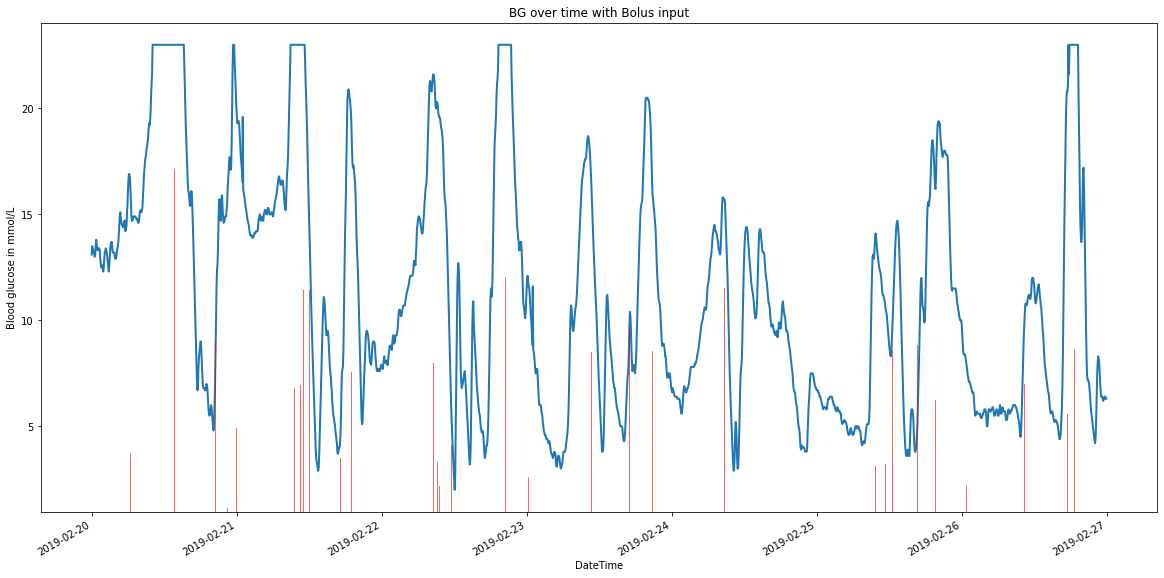

In [13]:
#graph
graph1 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

#bolus intake
max = filtered_idata['Bolus'].max()
for y in filtered_idata.loc[(filtered_idata['Bolus']>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolus = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus']>0),'Bolus'].sum())
  ymax = bolus*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end



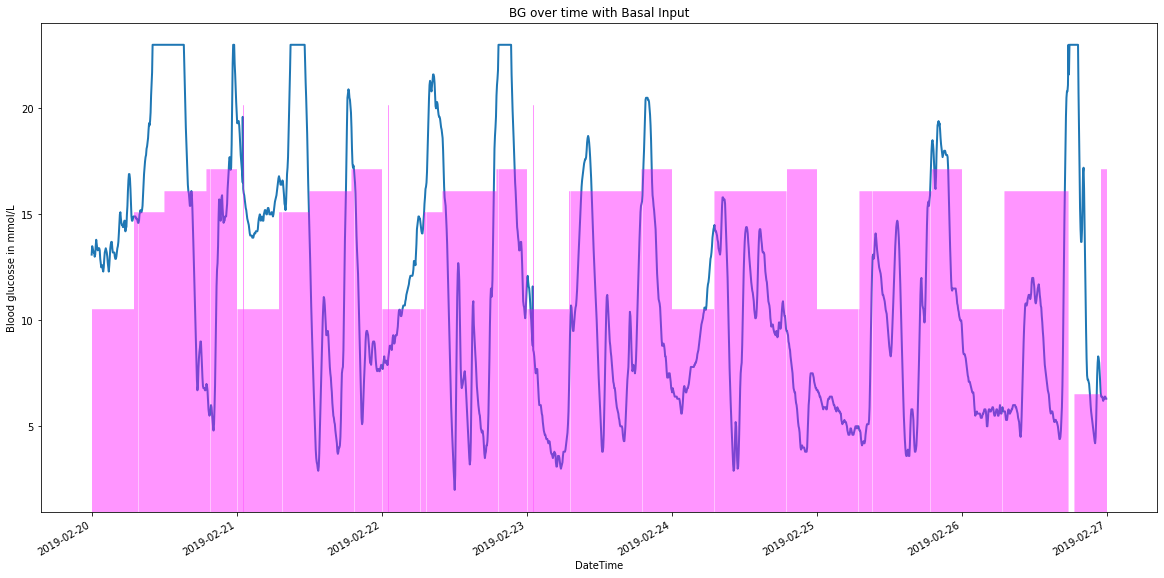

In [14]:
graph2 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Basal'].max()
for y in filtered_idata.loc[(filtered_idata['Basal']>0),:].index:
  basal = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Basal']>0),'Basal'].sum())
  ymax = basal*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


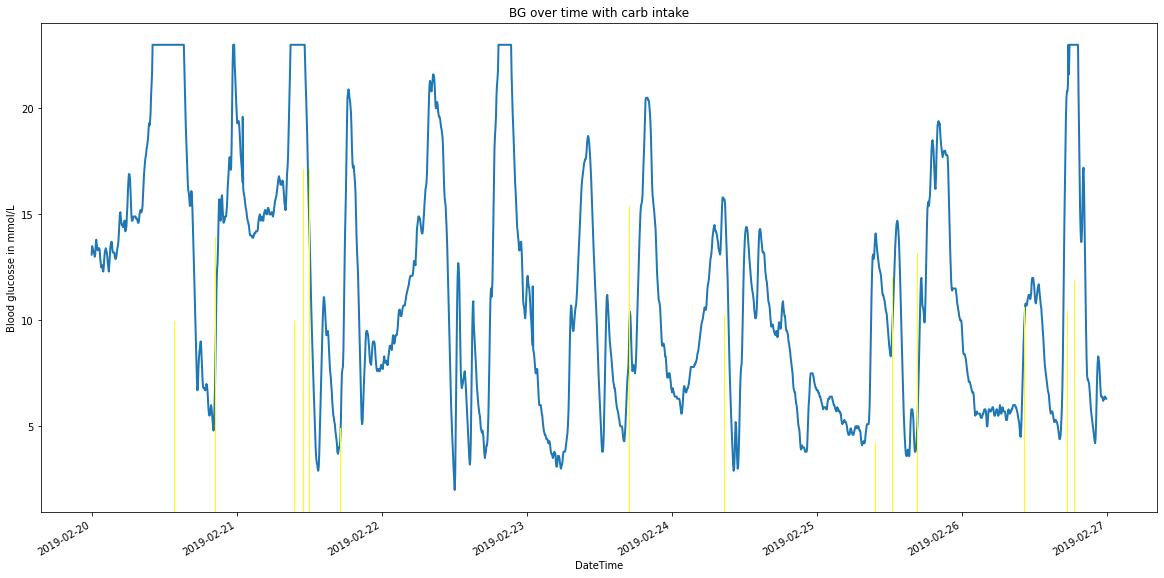

In [15]:
graph3 = filtered_idata['Glucose Value (mmol/L)'].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Carbs_gm'].max()
for y in filtered_idata.loc[(filtered_idata['Carbs_gm']>0),:].index:
  carbs = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Carbs_gm']>0),'Carbs_gm'].sum())
  ymax = carbs*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ffff00ff',lw=1) #remember, transparency at the end


# Train

## Config

In [16]:
#Model's Input
history_points = 120 #Number of history records needed to predict future BG value
batch_size=200 #Batch size of LSTM model execution
learning_rate=0.01 #Learning rate of LSTM model
validation_split=0.2 #validation data during training
prediction_horizon=3 #BG Prediction horizon: Value 1 = 5 minutes PH; Value 2 = 10 minutes PH; Value 6 = 30 minutes PH

## Create a training dataset

In [17]:
basal = 'basal'
bolus = 'bolus'
carbs = 'carbs'
bg = 'bg'
rename_legend= {
  'Basal':basal,
  'Bolus':bolus,
  'Carbs_gm':carbs, 
  'Glucose Value (mmol/L)':bg
}


In [18]:
train_data = filtered_idata.copy()
# dropped_features = ['Bolus Type','Immediate Volume (U)','Extended Volume (U)', 'Duration (min)']
# train_data.drop(dropped_features,1,inplace=True)
# temp_bg = filtered_bgdata.copy()
# do a manual join
# train_data['mmol/L'] = 0.0
print(len(train_data),'rows in training data')
# for index, row in temp_bg.iterrows():
#   # print(row[bg_unit],row.index)
#   l = train_data.loc[(train_data.index == index),bg_unit]
#   if len(l)>0:
#     train_data.loc[(train_data.index == index),bg_unit] = row[bg_unit]
#   else:
#     #insert a row
#     # print('inserting new row')
#     bg2 = row[bg_unit]
#     train_data = train_data.append(pd.Series({
#         'Basal Amount (U/h)':0.0, 
#         'Bolus Volume (U)':0.0, 
#         'Carbs(g)':0.0, 
#         bg_unit: bg2
#     }, name = index))
#     # train_data = pd.concat([train_data,df_new])

#rename columns
train_data.rename(rename_legend,axis=1,inplace=True)
train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
print(train_data.columns,'columns in training data')
print(len(train_data),'Data points in training data')
print(train_data)
print(train_data.info())

#Problem: The model is not working properly when intermittent glucose levels are not monitored.
# So we're setting them to the level last monitored
# train_data.sort_index(axis = 0,inplace=True)
# last_non_zero = 0.0
# for index,row in train_data.iterrows():
#   if(row[bg] <= 0):
#     row[bg] = last_non_zero
#   if(row[bg]>0):
#     last_non_zero = row[bg]
# train_data[bg].replace(0.0,np.nan,inplace=True)
# train_data[bg].interpolate(method='time',limit_direction ='forward',inplace=True)
# train_data[bg].fillna(0,inplace=True)
train_data.to_csv('train-test1.csv')

2016 rows in training data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in training data
576 Data points in training data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-21 01:00:00  19.6  0.079167    0.0      0
2019-02-21 00:05:00  19.3  0.079167    0.0      0
2019-02-21 00:10:00  19.3  0.079167    0.0      0
2019-02-21 00:15:00  19.4  0.079167    0.0      0
2019-02-21 00:20:00  19.4  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-22 23:35:00  10.6  0.133333    0.0      0
2019-02-22 23:40:00  10.3  0.133333    0.0      0
2019-02-22 23:45:00  10.1  0.133333    0.0      0
2019-02-22 23:50:00  10.4  0.133333    0.0      0
2019-02-22 23:55:00  11.0  0.133333    0.0      0

[576 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2019-02-21 01:00:00 to 2019-02-22 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  -

## Visualise training data

bg


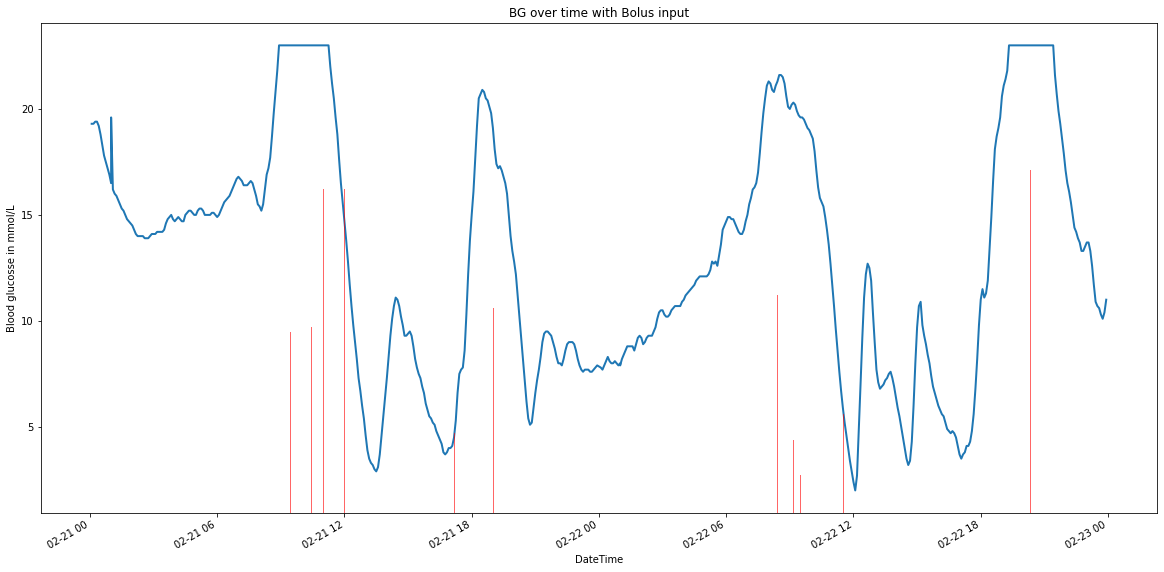

In [19]:
print(bg)
graph1 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

#bolus intake
max = train_data[bolus].max()
for y in train_data.loc[(train_data[bolus]>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolu = float(train_data.loc[(train_data.index==y) & (train_data[bolus]>0),bolus].sum())
  ymax = bolu*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end


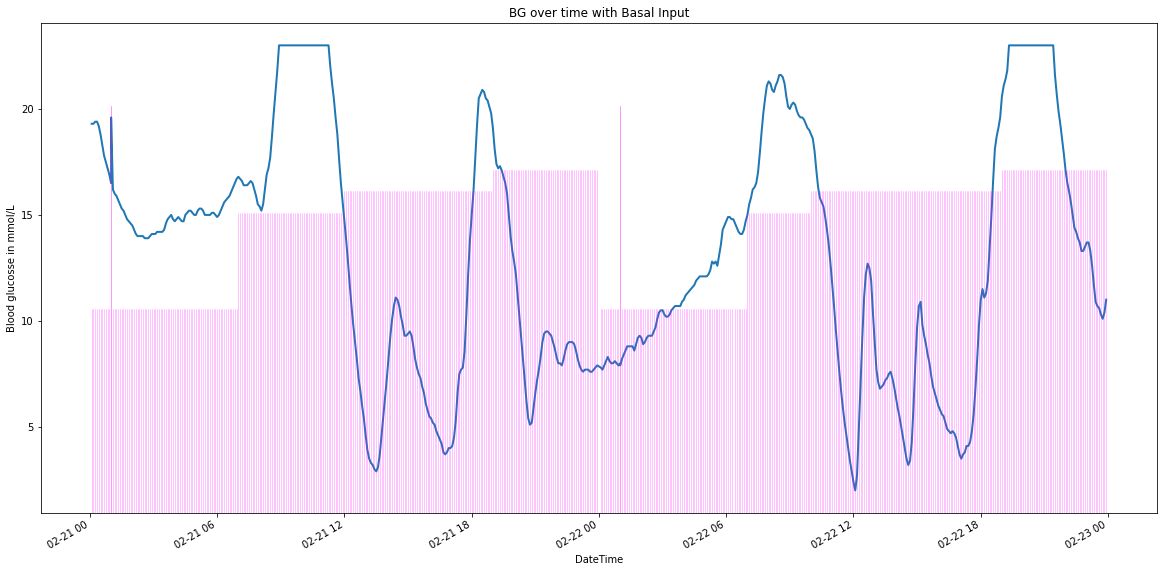

In [20]:
graph2 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = train_data[basal].max()
for y in train_data.loc[(train_data[basal]>0),:].index:
  basa = float(train_data.loc[(train_data.index==y) & (train_data[basal]>0),basal].sum())
  ymax = basa*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


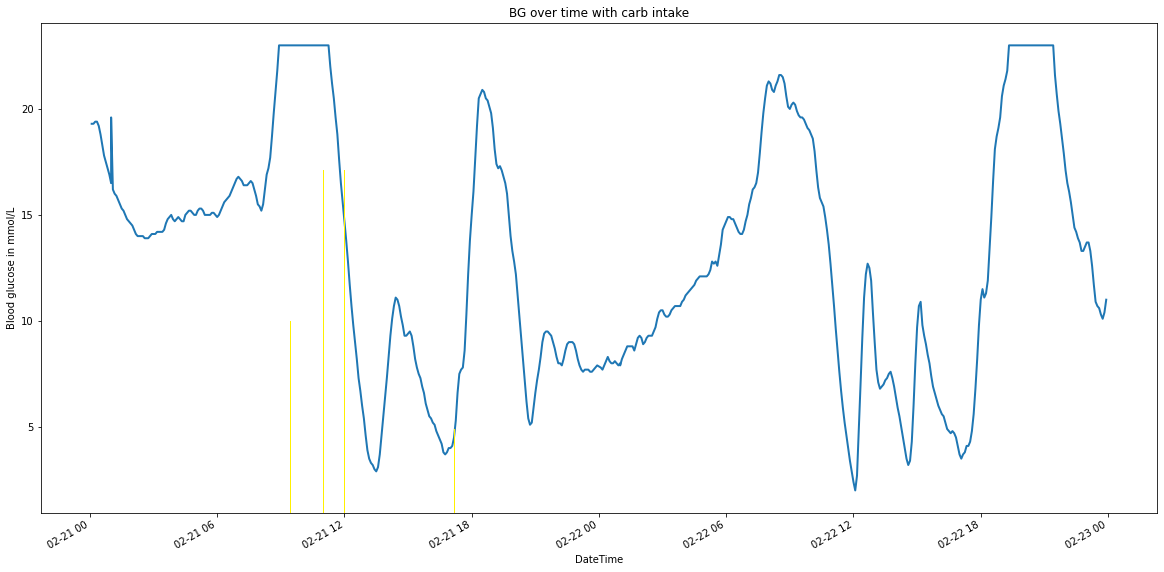

In [21]:
graph3 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

max = train_data[carbs].max()
for y in train_data.loc[(train_data[carbs]>0),:].index:
  carb = float(train_data.loc[(train_data.index==y) & (train_data[carbs]>0),carbs].sum())
  ymax = carb*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#fff000ff',lw=1) #remember, transparency at the end

## Prepare for training

In [22]:
normaliser = MinMaxScaler()
train_normalised_data = normaliser.fit_transform(train_data)

#For Denormalizing predicted BG data later
train_data_y = pd.DataFrame(train_data[bg])
scaler = MinMaxScaler()
scaler.fit_transform(train_data_y)

print(f'train_normalised_data_shape:{train_normalised_data.shape} \n', train_normalised_data)

#=========================================================================
#Preparing rows of data as a 3D-array of history points
#History points is the number of records needed to predict a future value

X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

print(f'X_train_shape:{X_train.shape} \n')
print(f'y_train_shape: {y_train.shape} \n')

train_normalised_data_shape:(576, 4) 
 [[0.83809524 0.59375    0.         0.        ]
 [0.82380952 0.59375    0.         0.        ]
 [0.82380952 0.59375    0.         0.        ]
 ...
 [0.38571429 1.         0.         0.        ]
 [0.4        1.         0.         0.        ]
 [0.42857143 1.         0.         0.        ]]
X_train_shape:(456, 120, 4) 

y_train_shape: (456,) 



# Model

## Design

In [23]:
tf.random.set_seed(20)
np.random.seed(20)

#input shape of the model
input_features = [bg,basal,bolus,carbs]
print(input_features)
input_shape=(history_points, len(input_features))

lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
inputs = Dropout(0.5, name='dropout_0')(lstm_input)
inputs = LSTM(50, return_sequences=True, name='lstm_1')(inputs)
inputs = Dropout(0.5, name='dropout_1')(inputs)
inputs = LSTM(50, return_sequences=True, name='lstm_2')(inputs)
inputs = Dropout(0.5, name='dropout_2')(inputs)
inputs = LSTM(50, name='lstm_3')(inputs) #Note: return_sequences=True not given here
inputs = Dropout(0.5, name='dropout_3')(inputs)
inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

#Model optimizer
adam = tf.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=adam, loss='mse')

#Model Summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

#Write output in a result file
write_string = short_model_summary
write_file( test_file_name, 'a', write_string)

['bg', 'basal', 'bolus', 'carbs']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 120, 4)]          0         
                                                                 
 dropout_0 (Dropout)         (None, 120, 4)            0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 50)           11000     
                                                                 
 dropout_1 (Dropout)         (None, 120, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 120, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 120, 50)           0         
                                                                 
 lstm_3 (LSTM)             

## Train

In [24]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

#Training and validation of data
start_time = time.time()
model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
elapsed_time = time.time() - start_time
n_epochs = len(model_training.history['loss'])
print('Training time: ', round(elapsed_time,2))


#Write output in a result file
write_string = f'Early stopping monitor: val_loss \nValidation split: {validation_split} \nNumber of epochs: {n_epochs} \nTraining time: {round(elapsed_time,2)} sec'
write_file( test_file_name, 'a', write_string)

Epoch 1/1000
2/2 [==============================] - 8s 2s/step - loss: 0.1930 - val_loss: 0.4631
Epoch 2/1000
2/2 [==============================] - 1s 471ms/step - loss: 0.4452 - val_loss: 0.3409
Epoch 3/1000
2/2 [==============================] - 1s 629ms/step - loss: 0.1628 - val_loss: 0.2215
Epoch 4/1000
2/2 [==============================] - 1s 480ms/step - loss: 0.1121 - val_loss: 0.1285
Epoch 5/1000
2/2 [==============================] - 1s 479ms/step - loss: 0.1013 - val_loss: 0.1089
Epoch 6/1000
2/2 [==============================] - 1s 484ms/step - loss: 0.0822 - val_loss: 0.1355
Epoch 7/1000
2/2 [==============================] - 1s 489ms/step - loss: 0.0817 - val_loss: 0.1407
Epoch 8/1000
2/2 [==============================] - 1s 497ms/step - loss: 0.0748 - val_loss: 0.1042
Epoch 9/1000
2/2 [==============================] - 1s 481ms/step - loss: 0.0622 - val_loss: 0.0729
Epoch 10/1000
2/2 [==============================] - 1s 493ms/step - loss: 0.0577 - val_loss: 0.0807
Ep

## Check fit - testing on training data

method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}

In [25]:
#=========================================================================
#Checking predictions of training data
#y-pred will return values equal to n-PH ahead
y_pred = model.predict(X_train)
y_pred = scaler.inverse_transform(y_pred)

#Getting the output equal to PH in a 2D array of 1 column
if prediction_horizon != 1:
    y_pred = y_pred[:,prediction_horizon-1]
    y_pred = np.reshape(y_pred, ((len(train_data)-history_points), 1))

y_pred.shape

#=========================================================================
#Predicted vs Actual value in training
#Adjusting y-pred data points consistent withactual y-values
train_result = train_data.iloc[history_points+prediction_horizon-1:]
train_result.rename(columns={bg: 'Actual Glucose Value (mmol/L)'}, inplace=True)
train_result['Predicted Glucose Value (mmol/L)'] = y_pred[:len(train_result),:] #Picking the first n predictions matching it with available actual value
train_result = train_result[['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)']] #Getting only Actual and Predicted values on mg/dl
# train_result['Actual Glucose Value (mmol/L)'] = train_result['Actual Glucose Value (mmol/L)'] / 18
# train_result['Predicted Glucose Value (mmol/L)'] = train_result['Predicted Glucose Value (mmol/L)'] / 18
train_result

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Actual Glucose Value (mmol/L),Predicted Glucose Value (mmol/L)
DateTime,,
2019-02-21 10:10:00,23.0,17.402491
2019-02-21 10:15:00,23.0,17.320509
2019-02-21 10:20:00,23.0,17.255407
2019-02-21 10:25:00,23.0,17.206068
2019-02-21 10:30:00,23.0,17.170275
...,...,...
2019-02-22 23:35:00,10.6,11.425242
2019-02-22 23:40:00,10.3,11.282649
2019-02-22 23:45:00,10.1,11.106043


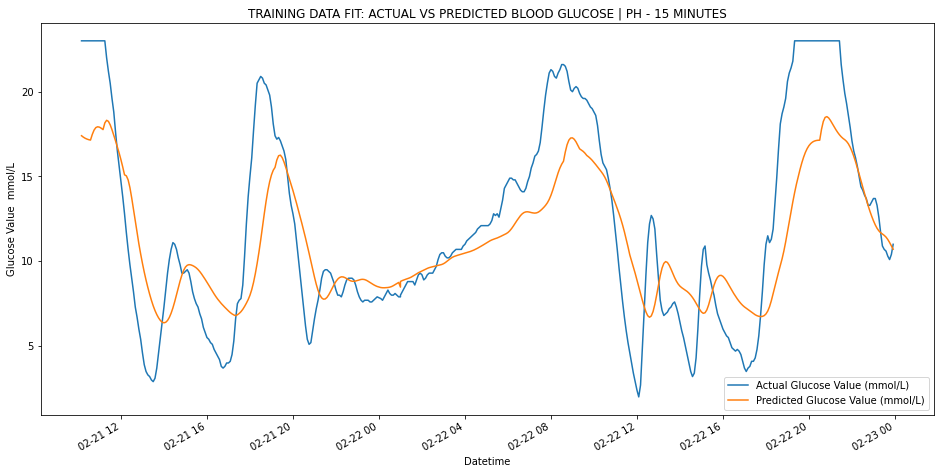

In [26]:
#=========================================================================
#Graph plot of training data fit
title = 'TRAINING DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
graph=train_result.plot.line(y=['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)'],figsize=(16,8),title=title)
graph.set(xlabel='Datetime',ylabel=bg_unit);

# Test on test data

## Create test dataset

In [27]:
test_data = filtered_idata.copy()
print(len(test_data),'rows in test data')

#rename columns
test_data.rename(rename_legend,axis=1,inplace=True)
test_data = test_data[ (test_data.index >= testing_date[0]) & (test_data.index <= testing_date[1]) ]
print(test_data.columns,'columns in test data')
print(len(test_data),'Data points in test data')
print(test_data)
print(test_data.info())
test_data.to_csv('test-data-1.csv')

2016 rows in test data
Index(['bg', 'basal', 'bolus', 'carbs'], dtype='object') columns in test data
288 Data points in test data
                       bg     basal  bolus  carbs
DateTime                                         
2019-02-23 01:00:00  11.6  0.079167    0.0      0
2019-02-23 00:05:00  12.0  0.079167    0.0      0
2019-02-23 00:10:00  12.1  0.079167    1.6      0
2019-02-23 00:15:00  11.8  0.079167    0.0      0
2019-02-23 00:20:00  11.6  0.079167    0.0      0
...                   ...       ...    ...    ...
2019-02-23 23:35:00   7.5  0.133333    0.0      0
2019-02-23 23:40:00   7.5  0.133333    0.0      0
2019-02-23 23:45:00   7.3  0.133333    0.0      0
2019-02-23 23:50:00   7.1  0.133333    0.0      0
2019-02-23 23:55:00   6.8  0.133333    0.0      0

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-02-23 01:00:00 to 2019-02-23 23:55:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -----

## Prep test data

In [28]:
test_normalised_data = normaliser.transform(test_data)
print(f'test_normalised_data_shape: {test_normalised_data.shape} \n', test_normalised_data)
#Preparing rows of test data as a 3D-array of history points
#History points is the number of records needed to predict a future value
X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
print(f'X_test_shape:{X_test.shape} \n')

test_normalised_data_shape: (288, 4) 
 [[0.45714286 0.59375    0.         0.        ]
 [0.47619048 0.59375    0.         0.        ]
 [0.48095238 0.59375    0.14814815 0.        ]
 ...
 [0.25238095 1.         0.         0.        ]
 [0.24285714 1.         0.         0.        ]
 [0.22857143 1.         0.         0.        ]]
X_test_shape:(168, 120, 4) 



## Create a smaller window

In [29]:
#=========================================================================
#Checking predictions of test data for one day window
#y-pred will return values equal to n-PH ahead

datapoints = 150

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:datapoints,:] #Picking 100 datapoints of test results = 1 Day of prediction

#Getting the output equal to PH in a 2D array of 1 column
if prediction_horizon != 1:
    y_pred = y_pred[:,prediction_horizon-1] #Picking last element from each predicted element array
    y_pred = np.reshape(y_pred, (datapoints, 1)) #Reshaping the 1D prediction to 2D array

y_pred.shape
#y_pred = y_pred[:283,0] #Used when history_points = 288

(150, 1)

## Predictions on test data

In [30]:
#=========================================================================
#Predicted vs Actual value in testing for one day
#Adjusting y-pred data points consistent with actual y-values
test_result = test_data.iloc[history_points+prediction_horizon-1: (history_points+prediction_horizon-1)+datapoints]
test_result.rename(columns={'bg': 'Actual Glucose Value (mg/dl)'}, inplace=True)

if len(test_result) != datapoints:
    print('Test data not enough for prediction.')
    print('Please check the values passed in history_points, prediction_horizon and length of test data.')
    
test_result['Predicted Glucose Value (mg/dl)'] = y_pred
test_result.to_csv('test_result.csv')
test_result = test_result[['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)']] #Getting only Actual and Predicted values on mg/dl
test_result['Actual Glucose Value (mmol/L)'] = test_result['Actual Glucose Value (mg/dl)'] / 18
test_result['Predicted Glucose Value (mmol/L)'] = test_result['Predicted Glucose Value (mg/dl)'] / 18

#Get prediction result file (Uncomment the below two lines to generate the file)
#prediction_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_Predictions{prediction_horizon*5}Min_{current_datetime}.xlsx'
#test_result.to_excel(prediction_file_name) #To get an excel file with prediction result
test_result

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Actual Glucose Value (mg/dl),Predicted Glucose Value (mg/dl),Actual Glucose Value (mmol/L),Predicted Glucose Value (mmol/L)
DateTime,,,,
2019-02-23 10:10:00,18.7,13.887093,1.038889,0.771505
2019-02-23 10:15:00,18.6,13.985720,1.033333,0.776984
2019-02-23 10:20:00,18.4,14.087558,1.022222,0.782642
2019-02-23 10:25:00,18.1,14.191418,1.005556,0.788412
2019-02-23 10:30:00,17.7,14.288811,0.983333,0.793823
...,...,...,...,...
2019-02-23 22:15:00,9.6,10.895403,0.533333,0.605300
2019-02-23 22:20:00,9.1,10.652518,0.505556,0.591807
2019-02-23 22:25:00,8.8,10.436096,0.488889,0.579783


## Visualise test data prediction

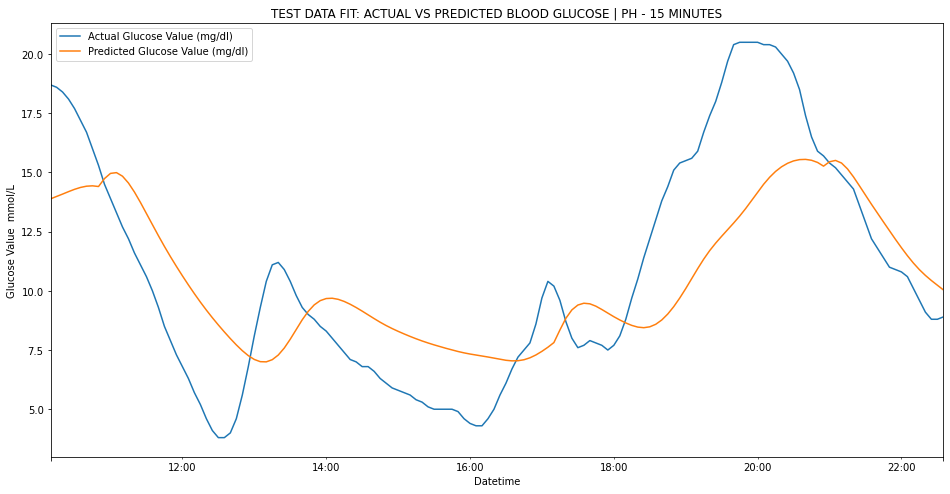

In [31]:
#=========================================================================
#Graph plot of test data predictions
title = 'TEST DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
graph=test_result.plot.line(y=['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)'],figsize=(16,8),title=title)
graph.set(xlabel='Datetime',ylabel=bg_unit);
#graph.figure.savefig('filename.jpg') #Saves the below graph in jpeg format

# Evaluating test data predictions

## RMSE

In [32]:
#Calclating RMSE between predicted and actual values

#Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#Converting actual BG value to numpy array
y_true = test_result.iloc[:,0].values #print(test_data.iloc[history_points+prediction_horizon-1:(history_points+prediction_horizon-1)+288, 0].values )
y_true = y_true.reshape(len(y_true),-1)
#print(y_true.shape)

#RMSE Value obtained
rmse_val = rmse(np.array(y_true), np.array(y_pred))
print(f'RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )')

#Write output in a result file
write_string = f'TEST DATA RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )'
write_file( test_file_name, 'a', write_string)

RMSE: 3.2 mg/dl (0.18 mmol/L )


## CG-EGA
https://github.com/dotXem/CG-EGA

*Something's wrong with this*

In [33]:
!git clone https://github.com/dotXem/CG-EGA
!mv CG-EGA cg_ega

Cloning into 'CG-EGA'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 103 (delta 4), reused 11 (delta 3), pack-reused 86
Receiving objects: 100% (103/103), 192.18 KiB | 7.12 MiB/s, done.
Resolving deltas: 100% (44/44), done.


AP, BE, EP: (1.0, 0.0, 0.0)


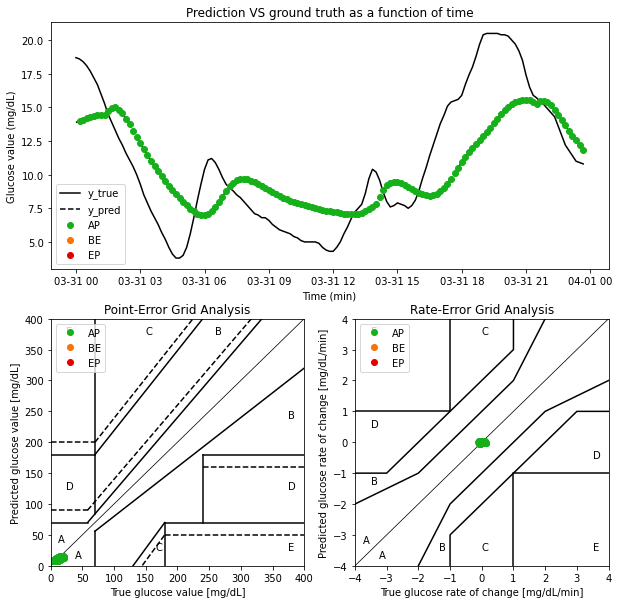

TEST DATA CG-EGA - AP: 1.0 | BE: 0.0 | EP: 0.0
Accurate Predictions: 100.0% 
Benign Errors: 0.0% 
Critical Error Predictions: 0.0%


In [34]:
#CG-EGA function
#Source: https://github.com/dotXem/CG-EGA

#Transposing the true and predicted value 
#as the CG-EGA function accepts 1D array as (1, values)
y_true = y_true.T
y_pred = y_pred.T
#Result of CG-EGA evaluation
from cg_ega.cg_ega.cg_ega import CG_EGA
freq = 10 #Time-interval in minutes
results = pd.DataFrame(data = np.c_[y_true.reshape(-1,1), y_pred.reshape(-1,1)], columns=["y_true","y_pred"])
cg_ega = CG_EGA(results, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=0)

#Write output in a result file
AP, BE, EP = cg_ega.reduced()
write_string = f'TEST DATA CG-EGA - AP: {round(AP,4)} | BE: {round(BE,4)} | EP: {round(EP,4)}'
write_string = write_string + f'\nAccurate Predictions: {round(AP,4)*100}% \nBenign Errors: {round(BE,4)*100}% \nCritical Error Predictions: {round(EP,4)*100}%'
write_file( test_file_name, 'a', write_string)
print(write_string)

# Prepare for API

In [ ]:
def train_for_api():
  # Create training set
  train_data = filtered_idata.copy()
  print(len(train_data),'rows in training data')

  #rename columns
  train_data.rename(rename_legend,axis=1,inplace=True)
  train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
  print(train_data.columns,'columns in training data')
  print(len(train_data),'Data points in training data')
  print(train_data)
  print(train_data.info())
  train_data.to_csv('train-test1.csv')

  # Prepare data
  normaliser = MinMaxScaler()
  train_normalised_data = normaliser.fit_transform(train_data)

  #For Denormalizing predicted BG data later
  train_data_y = pd.DataFrame(train_data[bg])
  scaler = MinMaxScaler()
  scaler.fit_transform(train_data_y)

  print(f'train_normalised_data_shape:{train_normalised_data.shape} \n', train_normalised_data)

  #=========================================================================
  #Preparing rows of data as a 3D-array of history points
  #History points is the number of records needed to predict a future value

  X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
  y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

  print(f'X_train_shape:{X_train.shape} \n')
  print(f'y_train_shape: {y_train.shape} \n')

  # Design model
  tf.random.set_seed(20)
  np.random.seed(20)

  #input shape of the model
  input_features = [bg,basal,bolus,carbs]
  print(input_features)
  input_shape=(history_points, len(input_features))

  lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
  inputs = Dropout(0.5, name='dropout_0')(lstm_input)
  inputs = LSTM(50, return_sequences=True, name='lstm_1')(inputs)
  inputs = Dropout(0.5, name='dropout_1')(inputs)
  inputs = LSTM(50, return_sequences=True, name='lstm_2')(inputs)
  inputs = Dropout(0.5, name='dropout_2')(inputs)
  inputs = LSTM(50, name='lstm_3')(inputs) #Note: return_sequences=True not given here
  inputs = Dropout(0.5, name='dropout_3')(inputs)
  inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
  output = Activation('linear', name='output')(inputs)
  model = Model(inputs=lstm_input, outputs=output)

  #Model optimizer
  adam = tf.optimizers.Adam(learning_rate = learning_rate)
  model.compile(optimizer=adam, loss='mse')

  #Model Summary
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  short_model_summary = "\n".join(stringlist)
  print(short_model_summary)

  #Write output in a result file
  write_string = short_model_summary
  write_file( test_file_name, 'a', write_string)
  # start training
  #Early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

  #Training and validation of data
  start_time = time.time()
  model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
  elapsed_time = time.time() - start_time
  n_epochs = len(model_training.history['loss'])
  print('Training time: ', round(elapsed_time,2))


  #Write output in a result file
  write_string = f'Early stopping monitor: val_loss \nValidation split: {validation_split} \nNumber of epochs: {n_epochs} \nTraining time: {round(elapsed_time,2)} sec'
  write_file( test_file_name, 'a', write_string)

def test_for_api():
  # Create test data
  test_data = filtered_idata.copy()
  print(len(test_data),'rows in test data')

  #rename columns
  test_data.rename(rename_legend,axis=1,inplace=True)
  test_data = test_data[ (test_data.index >= testing_date[0]) & (test_data.index <= testing_date[1]) ]
  print(test_data.columns,'columns in test data')
  print(len(test_data),'Data points in test data')
  print(test_data)
  print(test_data.info())
  test_data.to_csv('test-data-1.csv')

  # normalise
  test_normalised_data = normaliser.transform(test_data)
  print(f'test_normalised_data_shape: {test_normalised_data.shape} \n', test_normalised_data)
  #Preparing rows of test data as a 3D-array of history points
  #History points is the number of records needed to predict a future value
  X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
  print(f'X_test_shape:{X_test.shape} \n')

  #=========================================================================
  #Checking predictions of test data for one day window
  #y-pred will return values equal to n-PH ahead

  datapoints = 150

  y_pred = model.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  y_pred = y_pred[:datapoints,:] #Picking 100 datapoints of test results = 1 Day of prediction

  #Getting the output equal to PH in a 2D array of 1 column
  if prediction_horizon != 1:
      y_pred = y_pred[:,prediction_horizon-1] #Picking last element from each predicted element array
      y_pred = np.reshape(y_pred, (datapoints, 1)) #Reshaping the 1D prediction to 2D array

  y_pred.shape
  #y_pred = y_pred[:283,0] #Used when history_points = 288

  #=========================================================================
  #Predicted vs Actual value in testing for one day
  #Adjusting y-pred data points consistent with actual y-values
  test_result = test_data.iloc[history_points+prediction_horizon-1: (history_points+prediction_horizon-1)+datapoints]
  test_result.rename(columns={'bg': 'Actual Glucose Value (mg/dl)'}, inplace=True)

  if len(test_result) != datapoints:
      print('Test data not enough for prediction.')
      print('Please check the values passed in history_points, prediction_horizon and length of test data.')
  print('writing test results')
  test_result['Predicted Glucose Value (mg/dl)'] = y_pred
  test_result.to_csv('test_result.csv')
  test_result = test_result[['Actual Glucose Value (mg/dl)', 'Predicted Glucose Value (mg/dl)']] #Getting only Actual and Predicted values on mg/dl
  test_result['Actual Glucose Value (mmol/L)'] = test_result['Actual Glucose Value (mg/dl)'] / 18
  test_result['Predicted Glucose Value (mmol/L)'] = test_result['Predicted Glucose Value (mg/dl)'] / 18

  #Get prediction result file (Uncomment the below two lines to generate the file)
  #prediction_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_Predictions{prediction_horizon*5}Min_{current_datetime}.xlsx'
  #test_result.to_excel(prediction_file_name) #To get an excel file with prediction result
  test_result_name = 'outputs/test-result-'+str(prediction_horizon*5)+'.csv'
  print('saving test results to',test_result_name)
  test_result.to_csv(test_result_name)

  #Calclating RMSE between predicted and actual values

  #Converting actual BG value to numpy array
  y_true = test_result.iloc[:,0].values #print(test_data.iloc[history_points+prediction_horizon-1:(history_points+prediction_horizon-1)+288, 0].values )
  y_true = y_true.reshape(len(y_true),-1)
  #print(y_true.shape)

  #RMSE Value obtained
  rmse_val = rmse(np.array(y_true), np.array(y_pred))
  print(f'RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )')
  
  data[prediction_horizon*5] = {
      'rmse': round(rmse_val/18,2),
      'unit':'minutes',
      'start_date':training_start,
      'end_date:':training_end,
      'test_date':testing_date,
      'test_path':test_result_name
  }
  print('data written')

  #Write output in a result file
  # write_string = f'TEST DATA RMSE: {round(rmse_val,2)} mg/dl ({round(rmse_val/18,2)} mmol/L )'
  # write_file( test_file_name, 'a', write_string)

#Function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [ ]:
import json
!rm -rf outputs && mkdir outputs
data = {}
horizons = [1,3,6]
for horizon in horizons:
  prediction_horizon = horizon
  train_for_api()
  test_for_api()

data['user'] = {
    'name':patient_name,
    'gender':gender
}
dfile = open('outputs/data.json','w')
dfile.write(json.dumps(data))
print('data',data)